In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Animal Type Classifier: ResNet-50 (Tensorflow Hub)

In [98]:
import tensorflow as tf
import tensorflow_hub as hub

Reading CSV file (getting labels, types/classes, and file names)

In [99]:
labels_files = pd.read_csv('../input/animal-images-dataset/animal_data_img.csv')
labels_files

,Label,Animal_Type,Image_File
0,indian ringneck,Bird,animal_images/1633802583762_Indian Ringneck fo...
1,rottweiler puppy,Dog,animal_images/1633802583996_Rottweiler Puppy f...
2,rabbit,Rabbit,animal_images/1633802584211_Rabbit for sale.jpg
3,cokatail bird,Bird,animal_images/1633802584412_Cokatail bird for ...
4,apple konda pigeon,Bird,animal_images/1633802584634_Apple Konda Pigeon...
...,...,...,...
11954,à¶à·à¶à¶§à·à¶½à· à¶à·à¶»à·à¶½à·à¶½à¶±...,Bird,animal_images/1635693720508_à¶à·à¶à¶§à·à¶½...
11955,racing homer pigeons,Bird,animal_images/1635693743986_Racing Homer Pigeo...
11956,buruma aseel,Bird,animal_images/1635693744873_Buruma Aseel for s...
11957,pigeons,Bird,animal_images/1635693746008_Pigeons for sale.jpg


In [100]:
# Count of different animals
len(labels_files.Label.value_counts())

3618

In [101]:
# Count of different animals types
len(labels_files.Animal_Type.value_counts())

7

### Data Preprocessing and Preparing for Tensorflow Hub Model

In [102]:
labels_files.drop("Label", axis = 1, inplace = True)
labels_files

,Animal_Type,Image_File
0,Bird,animal_images/1633802583762_Indian Ringneck fo...
1,Dog,animal_images/1633802583996_Rottweiler Puppy f...
2,Rabbit,animal_images/1633802584211_Rabbit for sale.jpg
3,Bird,animal_images/1633802584412_Cokatail bird for ...
4,Bird,animal_images/1633802584634_Apple Konda Pigeon...
...,...,...
11954,Bird,animal_images/1635693720508_à¶à·à¶à¶§à·à¶½...
11955,Bird,animal_images/1635693743986_Racing Homer Pigeo...
11956,Bird,animal_images/1635693744873_Buruma Aseel for s...
11957,Bird,animal_images/1635693746008_Pigeons for sale.jpg


In [103]:
types = labels_files.Animal_Type.unique()
types

array(['Bird', 'Dog', 'Rabbit', 'Fish', 'Cat', 'Guinea pig / mouse',
       'Other'], dtype=object)

In [104]:
def preprocess_image(image_path, img_size = 224):
  """
  Takes an image path and turns the image into a tensor
  """
  # read the image 
  image = tf.io.read_file(image_path)
  
  # turn the jpg into a numerical Tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels = 3)

  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # resize the image to our desired value: 224, 224
  image = tf.image.resize(image, size = [img_size, img_size])

  return image

In [105]:
def get_image_and_label(image_path, label):
  """
  Takes an image filepath and the asociated label, preprocess the image and return a tuple of (image, label)
  """
  image = preprocess_image(image_path)
  return image, label

In [106]:

def create_databatches(X, y = None, batch_size = 32, valid_data = False, test_data = False):
  """
  Create batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data and doesn't shuffle it if it is validation data,
  also accepts test data as input (no labels) 
  """

  # if the data is the test dataset, we dont have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #filepaths 
    data_batch = data.map(preprocess_image).batch(batch_size)
    print('Done t!')
    return data_batch
  
  # if the data is a valid dataset, we dont need to shuffle it 
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_and_label).batch(batch_size)
    print('Done! v')
    return data_batch
  
  else: 
    print('Creating training data batches...')
    # turn filepaths and labels into tensors 
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    # shuffle pathnames and labels before maping image processing function is faster than shuffeling images 
    data = data.shuffle(buffer_size = len(X))

    # create (image, labels) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_and_label)

    # turn the training data into batches 
    data_batch = data.batch(batch_size)
    print('Done! tr')
    return data_batch 

In [107]:
bool_labels = [label == types for label in labels_files.Animal_Type]

In [108]:
filepaths = ['../input/animal-images-dataset/animal_images/' + path for path in labels_files.Image_File]

In [109]:
from sklearn.model_selection import train_test_split

slice_sice = 100000

X = filepaths[:slice_sice]
y = bool_labels[:slice_sice]

# split into training and validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

len(X_train), len(X_test), len(y_train), len(y_test)

(10165, 1794, 10165, 1794)

In [110]:
train_data = create_databatches(X_train, y_train)
valid_data = create_databatches(X_test, y_test, valid_data = True) 

Creating training data batches...
Done! tr
Creating validation data batches...
Done! v


In [111]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)

In [112]:
model_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'
input_shape = [None, 224, 224, 3] # [batch, height, width, color channels]

# setup the output shape 
output_shape = len(types)

In [113]:
# setup the layers
model = tf.keras.Sequential([
  hub.KerasLayer(model_url), # TF Hub model (ResNet-50)
  tf.keras.layers.Dense(units = output_shape, activation = 'softmax') # Dense layer
])

# compile the model
model.compile(
  loss = tf.keras.losses.CategoricalCrossentropy(),
  optimizer = tf.keras.optimizers.Adam(),
  metrics = ['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)

# Build the model
model.build(input_shape)

In [114]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              25615849  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 7014      
Total params: 25,622,863
Trainable params: 7,014
Non-trainable params: 25,615,849
_________________________________________________________________


### Training :D

In [115]:
history = model.fit(
      x = train_data,
      epochs = 100,
      validation_data = valid_data,
      validation_freq = 1,
      callbacks = [early_stop]
  )

Epoch 1/100
318/318 [==============================] - 22s 58ms/step - loss: 0.4890 - accuracy: 0.8656 - val_loss: 0.3206 - val_accuracy: 0.9136
Epoch 2/100
318/318 [==============================] - 18s 57ms/step - loss: 0.2491 - accuracy: 0.9258 - val_loss: 0.2811 - val_accuracy: 0.9192
Epoch 3/100
318/318 [==============================] - 18s 57ms/step - loss: 0.2057 - accuracy: 0.9382 - val_loss: 0.2990 - val_accuracy: 0.9192
Epoch 4/100
318/318 [==============================] - 18s 56ms/step - loss: 0.1775 - accuracy: 0.9467 - val_loss: 0.2695 - val_accuracy: 0.9231
Epoch 5/100
318/318 [==============================] - 18s 57ms/step - loss: 0.1629 - accuracy: 0.9485 - val_loss: 0.2823 - val_accuracy: 0.9270
Epoch 6/100
318/318 [==============================] - 18s 56ms/step - loss: 0.1503 - accuracy: 0.9541 - val_loss: 0.2774 - val_accuracy: 0.9326
Epoch 7/100
318/318 [==============================] - 18s 57ms/step - loss: 0.1427 - accuracy: 0.9558 - val_loss: 0.2889 - val_ac

In [116]:
def get_predicted_label(predictions_probabilities):
  """
  Turns an array of predictions probabilities into a label
  """
  return types[predictions_probabilities.argmax()]

def plot_prediction(prediction_probabilities, labels, images, n = 0, test_data = False):
  """
  View the prediction, ground truth and image for a sample n
  """
  if test_data: 
    labels = ['']
  pred_prob, true_label, img = prediction_probabilities[n], labels[n], images[n]

  # get the predicted label
  pred_label = get_predicted_label(pred_prob)

  # plot the image
  plt.imshow(img)
  plt.axis('off')
  
  # Change the color of the title depending on if the prediction is right or wrong  
  
  if pred_label == true_label:
    color = 'green' 
  elif test_data:
    color = 'black'
  else:
    color = 'red'


  if not test_data:
    # Change plot title to be: 'predicted label (predict_proba) true: true_label'
    plt.title('{} {:2.0f}%, true: {}'.format(pred_label, np.max(pred_prob) * 100, true_label), color = color)
  else: 
    plt.title('{} {:2.0f}%'.format(pred_label, np.max(pred_prob) * 100), color = color)

In [117]:
y_preds = model.predict(valid_data)

In [118]:
y_preds

array([[5.39795496e-04, 9.99240637e-01, 6.34675962e-06, ...,
        4.33987152e-05, 7.15176185e-08, 3.83090359e-08],
       [5.59349201e-06, 9.98508155e-01, 1.47096898e-05, ...,
        1.46853295e-03, 4.35420731e-07, 2.49993286e-06],
       [9.99874830e-01, 1.51758819e-08, 6.24337275e-08, ...,
        1.31729445e-08, 3.23782973e-10, 8.88804419e-10],
       ...,
       [1.85322438e-04, 9.99697804e-01, 5.09124902e-06, ...,
        5.65595087e-07, 2.44772073e-05, 1.46719245e-07],
       [6.13002863e-04, 9.97825563e-01, 1.73401600e-06, ...,
        1.21750473e-03, 3.05647496e-04, 5.85688304e-06],
       [1.74129764e-05, 1.94247173e-06, 1.93761953e-05, ...,
        1.24109633e-07, 2.00134650e-07, 4.11759267e-08]], dtype=float32)

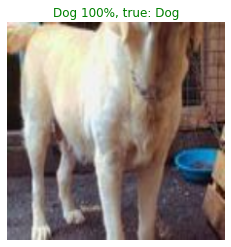

In [119]:
true_test_labels = [get_predicted_label(l) for l in y_test]
test_images = [preprocess_image(img) for img in X_test]

plot_prediction(y_preds, true_test_labels, test_images, n = 0, test_data = False)

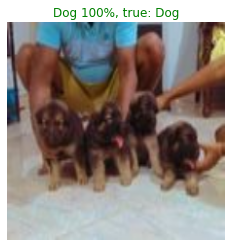

In [120]:
plot_prediction(y_preds, true_test_labels, test_images, n = 127, test_data = False)

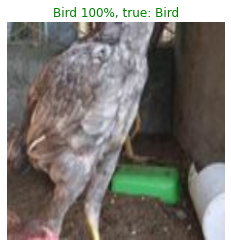

In [121]:
plot_prediction(y_preds, true_test_labels, test_images, n = 52, test_data = False)

In [122]:
def show_prediction(prediction_probabilities, labels, images, n = 0, test_data = False):
  """
  View the prediction, ground truth and image for a sample n
  """
  if test_data: 
    labels = ['']
  pred_prob, true_label, img = prediction_probabilities[n], labels[n], images[n]

  # get the predicted label
  pred_label = get_predicted_label(pred_prob)
  print(pred_label)
  
  # Change the color of the title depending on if the prediction is right or wrong  
  
  if pred_label == true_label:
    color = 'green' 
  elif test_data:
    color = 'black'
  else:
    color = 'red'

In [123]:
show_prediction(y_preds, true_test_labels, test_images, n = 52, test_data = False)

Bird


In [124]:
predicted_classes = [pred.argmax() for pred in y_preds]
true_classes = [true_label.argmax() for true_label in y_test]

In [125]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=types))

                    precision    recall  f1-score   support

              Bird       0.93      0.93      0.93       615
               Dog       0.96      0.96      0.96       584
            Rabbit       0.83      0.85      0.84        84
              Fish       0.92      0.95      0.93       418
               Cat       0.83      0.77      0.80        57
Guinea pig / mouse       0.83      0.58      0.68        33
             Other       0.00      0.00      0.00         3

          accuracy                           0.93      1794
         macro avg       0.76      0.72      0.73      1794
      weighted avg       0.92      0.93      0.92      1794



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Forgot to check dataset distribution...

<AxesSubplot:>

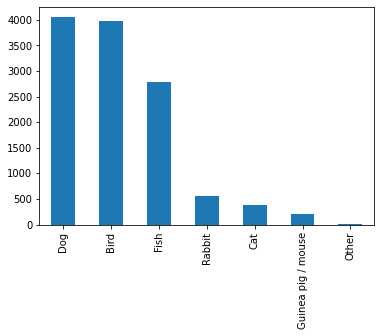

In [126]:
labels_files.Animal_Type.value_counts().plot(kind = 'bar')

### Accuracy, Loss

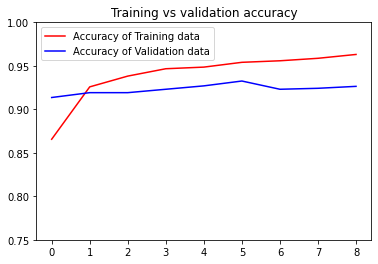

<Figure size 432x288 with 0 Axes>

In [127]:
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))

plt.ylim([0.75, 1])
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

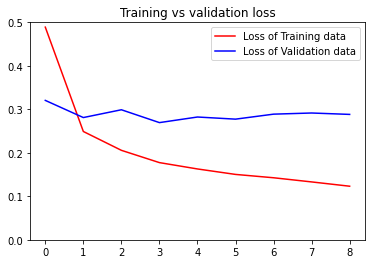

<Figure size 432x288 with 0 Axes>

In [128]:
epochs = range(len(get_loss))

plt.ylim([0,0.5])
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [129]:
from PIL import Image
from urllib import request
from io import BytesIO

### Predict animal type from external input image

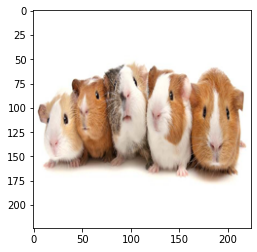

In [146]:
url = 'https://cdn.britannica.com/93/150093-050-A20009B5/guinea-pigs-coloration.jpg'
res = request.urlopen(url).read()
img = Image.open(BytesIO(res)).convert('RGB')
img = img.resize((224, 224))

img_array = np.array(img)
img_array = img_array/255.0

img_tensor = np.expand_dims(img_array, axis=0)

plt.imshow(img)

In [147]:
pred_new = model.predict(img_tensor)
pred_new

array([[2.9533514e-05, 2.3767548e-06, 2.5732765e-02, 1.2465820e-06,
        4.6768786e-08, 9.7418743e-01, 4.6672129e-05]], dtype=float32)

In [148]:
get_predicted_label(pred_new)

'Guinea pig / mouse'

### Saving the model (alhamdulillah)

In [134]:
model.save('dafrom_model.h5')

In [135]:
import tensorflow_hub as hub

new_model = tf.keras.models.load_model('dafrom_model.h5', custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              25615849  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 7014      
Total params: 25,622,863
Trainable params: 7,014
Non-trainable params: 25,615,849
_________________________________________________________________
